## Testing NC backboning over time (across 20 years)

Playing around with the module in util (had to write one from scratch as there is no noise corrected function in the backbone module) and different alpha values

In [14]:
import sys
import os
import pandas as pd
import networkx as nx


# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.nc_backbone import nc_backbone
from util.project import project
from util.get_edge_list import get_edge_list
from util.merge_fams import merge_fams

df = merge_fams('../data/CosciaRios2012_DataBase.csv')
min_year = df['Year'].min()
max_year = df['Year'].max()
families = df.columns[3:]

alpha_value = 0.4
G_backboned = {}
G_original = {}
edges_evol = {'year': [], 'bb_edges': [], 'og_edges': []}

for year in range(min_year, max_year + 1):
    df_year = df[df['Year'] == year]
    adj = project(df_year, on_municipalities=False)
    edge_list = get_edge_list(adj)

    G_original[year] = nx.Graph()
    G_original[year].add_nodes_from(families)
    G_original[year].add_weighted_edges_from(edge_list)

    bb_edge_list = nc_backbone(adj, alpha=alpha_value)

    G_backboned[year] = nx.Graph()
    G_backboned[year].add_nodes_from(families)
    G_backboned[year].add_weighted_edges_from(bb_edge_list)

    edges_evol['year'].append(year)
    edges_evol['bb_edges'].append(nx.density(G_backboned[year]))
    edges_evol['og_edges'].append(nx.density(G_original[year]))
    
df_edges_evol = pd.DataFrame(edges_evol)
df_edges_evol

,year,bb_edges,og_edges
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.035714
3,1993,0.071429,0.071429
4,1994,0.000000,0.071429
5,1995,0.035714,0.071429
6,1996,0.071429,0.142857
7,1997,0.035714,0.035714
8,1998,0.107143,0.142857
9,1999,0.071429,0.071429


How ideal is the alpha value?  
We don't want to isolate nodes that belong to the connected component before backboning

In [15]:
# Check for isolated nodes
for year in range(1990, 2011):
    isolated_orig = list(nx.isolates(G_original[year]))
    isolated_bb = list(nx.isolates(G_backboned[year]))
    new_isolated = set(isolated_bb) - set(isolated_orig)

    conn_comp_og = nx.number_connected_components(G_original[year])
    conn_comp_bb = nx.number_connected_components(G_backboned[year])

    print(f"{year}: {conn_comp_og} in the original network, {conn_comp_bb} in the backboned network")
    if new_isolated:
        print(f"\t Nodes {new_isolated} became isolated")

1990: 8 in the original network, 8 in the backboned network
1991: 8 in the original network, 8 in the backboned network
1992: 7 in the original network, 8 in the backboned network
	 Nodes {'Tijuana', 'Zetas'} became isolated
1993: 6 in the original network, 6 in the backboned network
1994: 6 in the original network, 8 in the backboned network
	 Nodes {'Golfo', 'Tijuana', 'Zetas'} became isolated
1995: 6 in the original network, 7 in the backboned network
	 Nodes {'Juarez'} became isolated
1996: 5 in the original network, 6 in the backboned network
1997: 7 in the original network, 7 in the backboned network
1998: 4 in the original network, 5 in the backboned network
1999: 6 in the original network, 6 in the backboned network
2000: 5 in the original network, 6 in the backboned network
2001: 3 in the original network, 4 in the backboned network
2002: 4 in the original network, 4 in the backboned network
2003: 2 in the original network, 2 in the backboned network
2004: 1 in the original ne

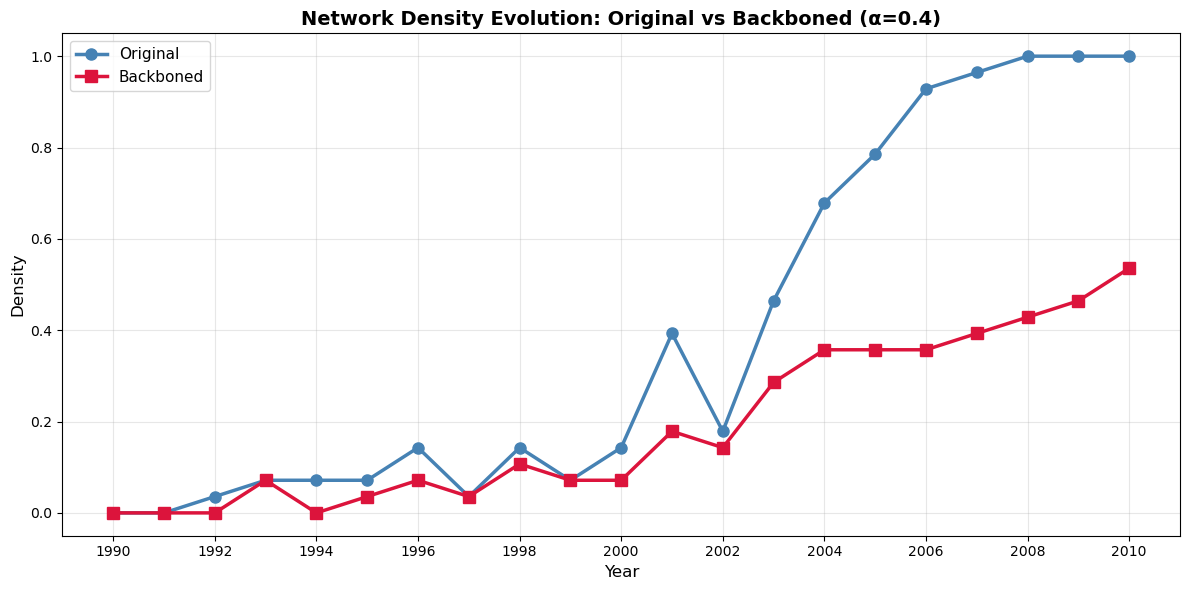

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_edges_evol['year'], df_edges_evol['og_edges'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_edges_evol['year'], df_edges_evol['bb_edges'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Network Density Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

Smaller (and more reasonable) alpha values lead to very sparse backbones :(  


### Ridiculogram: 

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

min_year = min(G_backboned.keys())
max_year = max(G_backboned.keys())
max_weight = 189 #hard coded from previous eda cartel projection notebook

G_og_2010 = G_original[2010]

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the last state
pos = nx.spring_layout(G_og_2010, weight='weight', seed=42) #nodes with higher weights are closer together

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    G = G_backboned[year]
    year_edges = G.edges()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 5  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6)    

    plt.title(f"NC Backboned Family Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'bb_network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_6600\2013599106.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'bb_network_evolution.gif'


After visually inspecting this backboned projection, we observe some edges appear and disappear depending on the year, in contrast with the original projection where edges stay almost always and only get thicker.

Backboning on collapsed network

Edges in backboned nw: 13


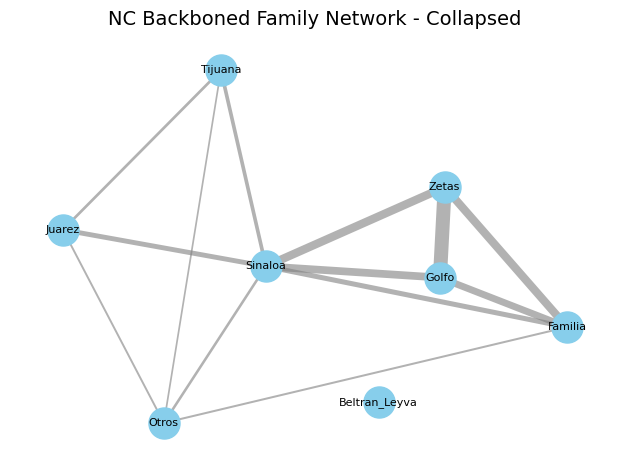

In [19]:
df_collapsed = df.groupby('Code').sum()
df_collapsed = (df_collapsed > 0).astype(int)

collapsed_adj = project(df_collapsed, on_municipalities=False)
collapsed_nc_edge_list = nc_backbone(collapsed_adj, alpha=alpha_value)
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(families)
G_collapsed.add_weighted_edges_from(collapsed_nc_edge_list)

np.array(G_collapsed.edges(data='weight'))

collapsed_weights = (np.array(list(G_collapsed.edges(data='weight'))))[:,2].astype(int)
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

print(f"Edges in backboned nw: {G_collapsed.number_of_edges()}")

plt.title(f"NC Backboned Family Network - Collapsed", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Surprisingly, the nc backboned collapsed network has way less edges than expected for the same alpha value. This suggests that the approach should be to either work with backboned time networks on a specific α or with the collapsed network at another alpha value.

### Stick to timed network
For completeness, we will mainly work with timed data, and compare results to collapsed network to analyze meaningful differences.

### Degree distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

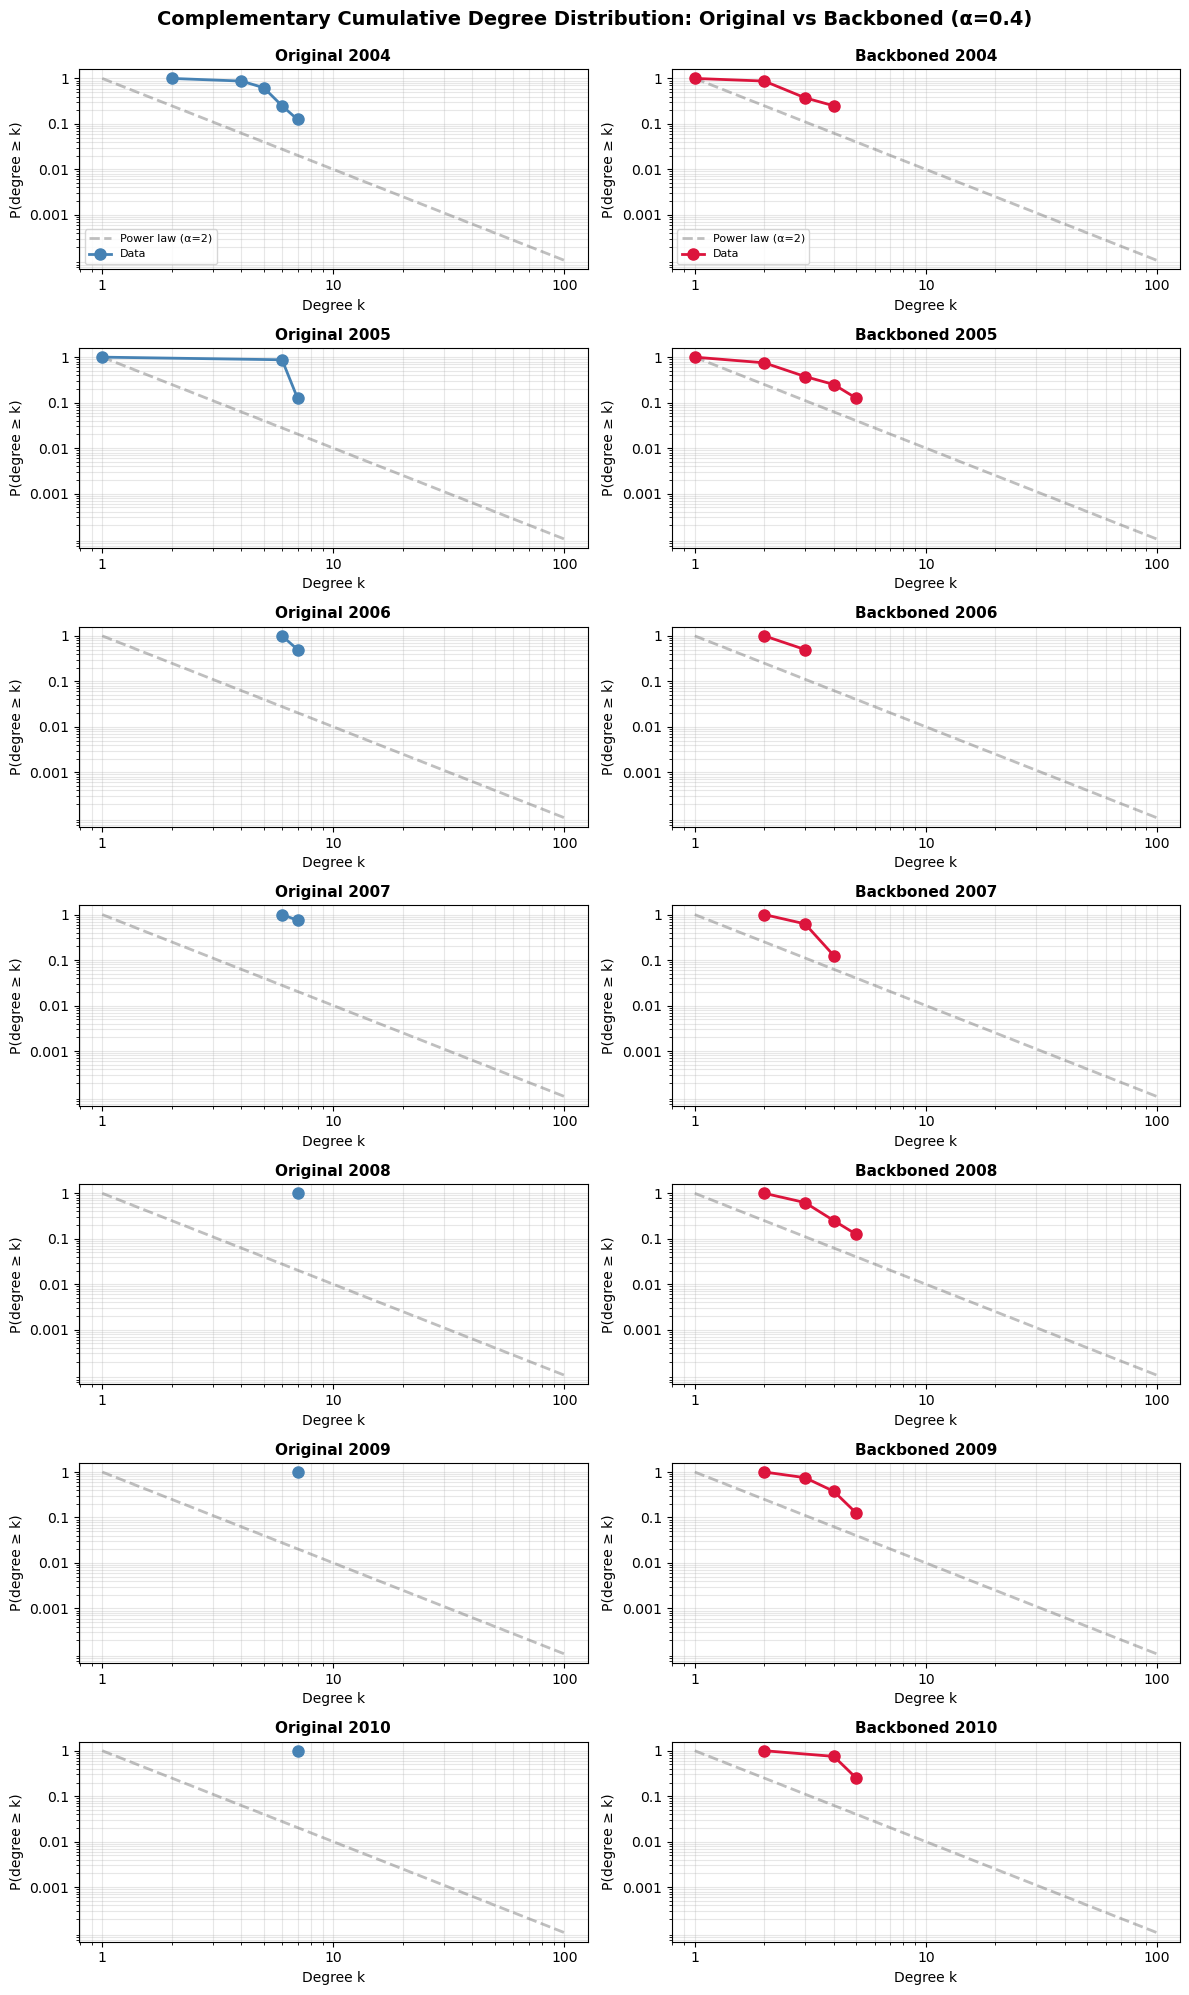

In [20]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law: P(k) = k^(-alpha)
k_ref = np.linspace(1, 100, 100)
power_law_alpha = 2
power_law_ref = k_ref**(-power_law_alpha)  # Power law with exponent -1

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    degrees_orig = np.array(list(dict(G_original[year].degree()).values()))
    total_nodes = G_original[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees, counts = np.unique(degrees_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_nodes  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_orig.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees) > 0:
        ax_orig.loglog(unique_degrees, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Degree k', fontsize=10)
    ax_orig.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    degrees_bb = np.array(list(dict(G_backboned[year].degree()).values()))
    total_nodes_bb = G_backboned[year].number_of_nodes()
    
    # Get unique degrees and counts, then compute CCDF efficiently
    unique_degrees_bb, counts_bb = np.unique(degrees_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_nodes_bb  # reverse cumsum for CCDF
    
    # Plot reference power law first (behind data)
    ax_bb.loglog(k_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_degrees_bb) > 0:
        ax_bb.loglog(unique_degrees_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2, label='Data')
    
    ax_bb.set_xlabel('Degree k', fontsize=10)
    ax_bb.set_ylabel('P(degree ≥ k)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Degree Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Impossible to state there is any kind of power law behavior, as the small number of nodes N limits the exponential behavior: the degree k has a max value of 9 and the power law follows the structure:
p(k) ~ k^(-α), meaning that as k → inf, p → 0. Besides, most nodes in the network have a degree of 1 as most real word networks are sparse, but in this case they are usually very dense. We tested at α=2 because real world power law networks have 2 ≤ α ≤ 5. What we can see that the backboning did a good job in removing edges such that nodes have more diverse degrees. 

**Better wording: With 𝑁 = 10, the degree distribution has no asymptotic regime, making any claim of power-law behavior or cutoff meaningless; the observed CCDF curvature is entirely due to finite-size constraints**

---

### Edge weight distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

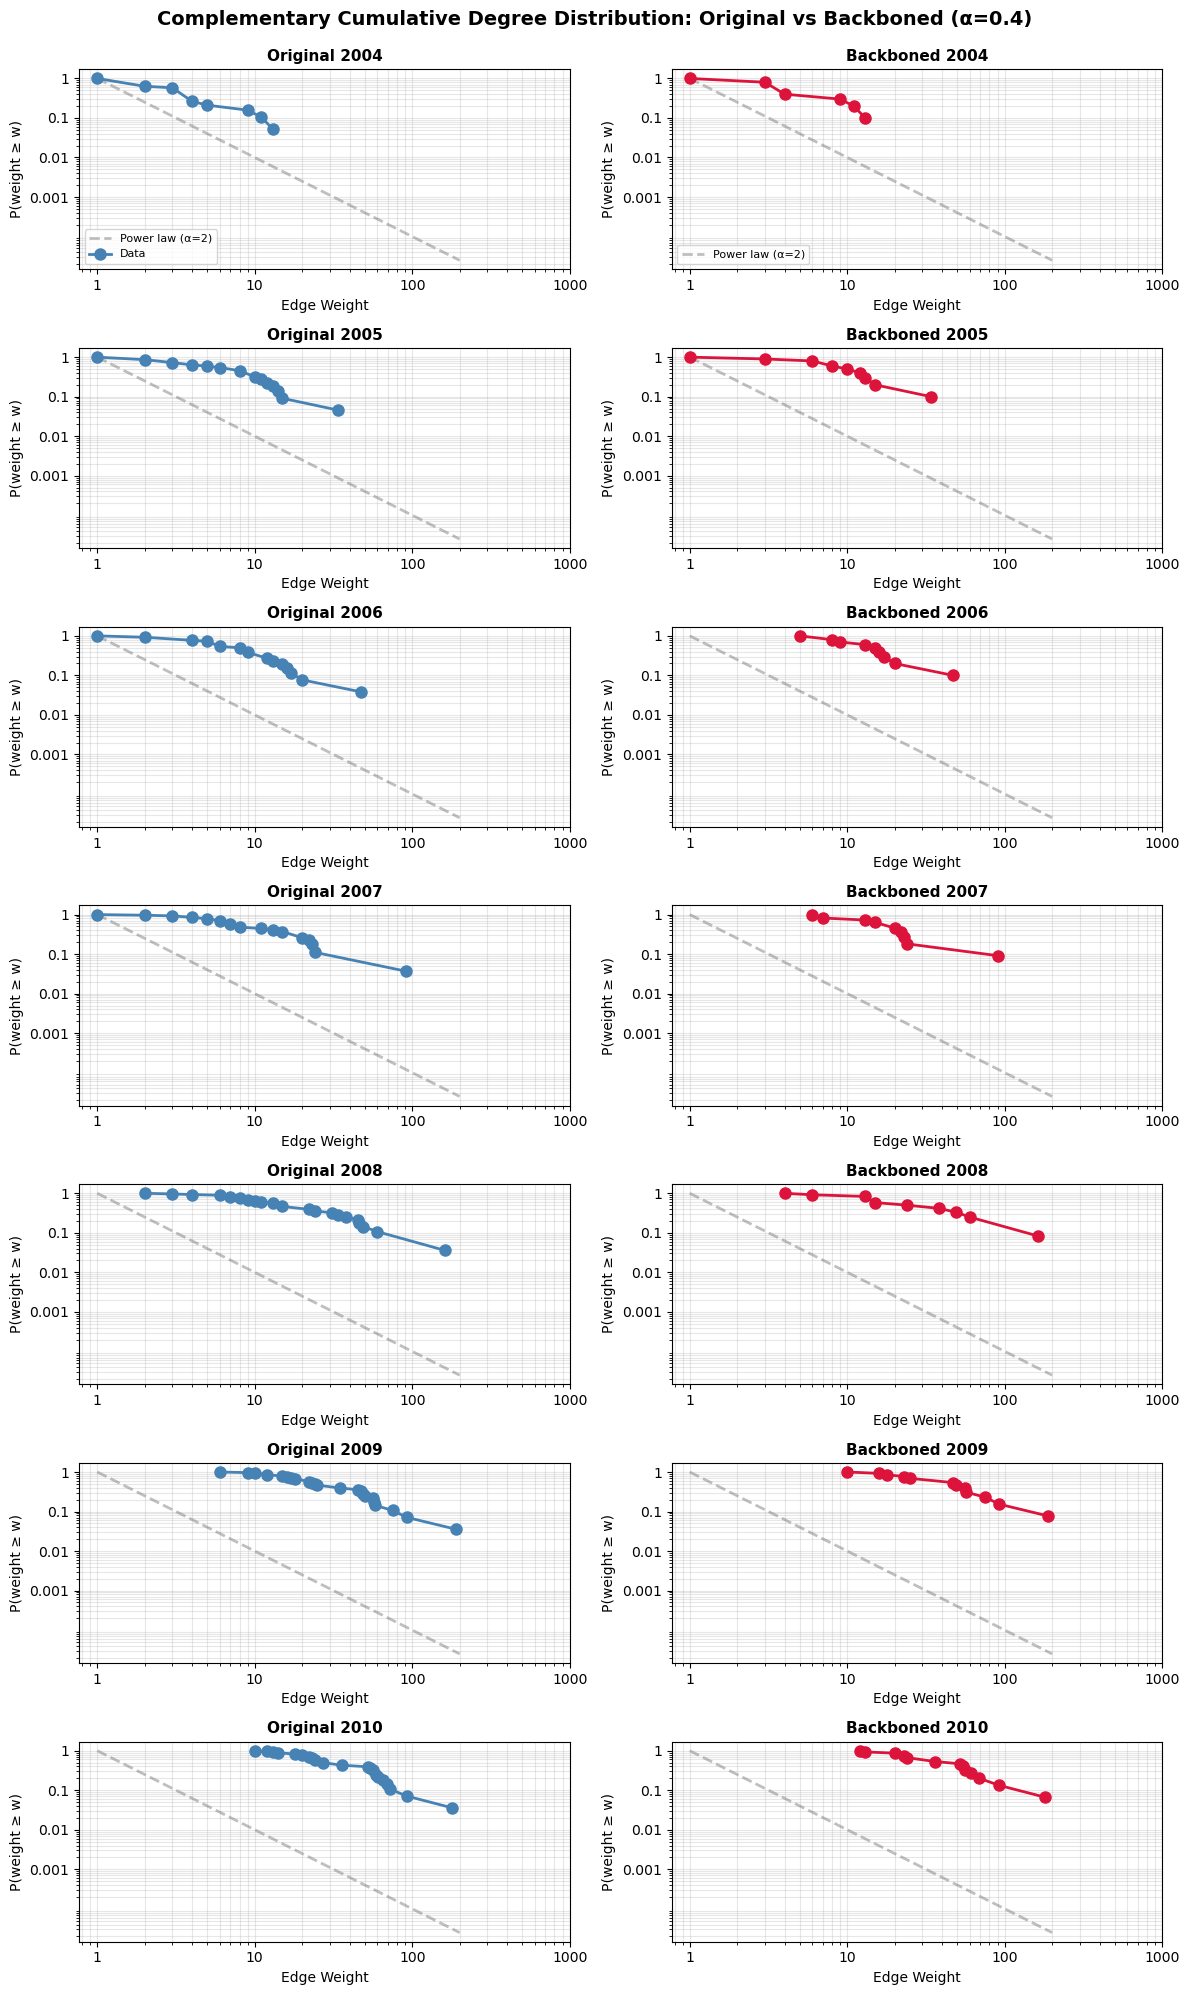

In [21]:
# Create 7x2 plot comparing complementary cumulative degree distributions (optimized)
import numpy as np

years_to_plot = list(range(2004, 2011))
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

# Create reference power law for edge weights
w_ref = np.linspace(1, 200, 200)
power_law_alpha = 2
power_law_ref = w_ref**(-power_law_alpha)

for i, year in enumerate(years_to_plot):
    # Original network CCDF (left column)
    ax_orig = axes[i, 0]
    weights_orig = np.array(list(G_original[year].edges(data='weight')))[:,2].astype(int)
    total_edges = len(weights_orig)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights, counts = np.unique(weights_orig, return_counts=True)
    ccdf_orig = np.cumsum(counts[::-1])[::-1] / total_edges  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_orig.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights) > 0:
        ax_orig.loglog(unique_weights, ccdf_orig, 'o-', color='steelblue', markersize=8, linewidth=2, label='Data')
    
    ax_orig.set_xlabel('Edge Weight', fontsize=10)
    ax_orig.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_orig.set_title(f'Original {year}', fontsize=11, fontweight='bold')
    ax_orig.grid(True, alpha=0.3, which='both')
    ax_orig.set_xticks([1, 10, 100, 1000])
    ax_orig.set_yticks([0.001, 0.01, 0.1, 1])
    ax_orig.set_xticklabels(['1', '10', '100', '1000'])
    ax_orig.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_orig.legend(fontsize=8, loc='lower left')
    
    # Backboned network CCDF (right column)
    ax_bb = axes[i, 1]
    weights_bb = np.array(list(G_backboned[year].edges(data='weight')))[:,2].astype(int)
    total_edges_bb = len(weights_bb)
    
    # Get unique weights and counts, then compute CCDF efficiently
    unique_weights_bb, counts_bb = np.unique(weights_bb, return_counts=True)
    ccdf_bb = np.cumsum(counts_bb[::-1])[::-1] / total_edges_bb  # reverse cumsum for CCDF

    # Plot reference power law first (behind data)
    ax_bb.loglog(w_ref, power_law_ref, '--', color='gray', linewidth=2, alpha=0.5, label=f'Power law (α={power_law_alpha})')
    
    if len(unique_weights_bb) > 0:
        ax_bb.loglog(unique_weights_bb, ccdf_bb, 'o-', color='crimson', markersize=8, linewidth=2)
    
    ax_bb.set_xlabel('Edge Weight', fontsize=10)
    ax_bb.set_ylabel('P(weight ≥ w)', fontsize=10)
    ax_bb.set_title(f'Backboned {year}', fontsize=11, fontweight='bold')
    ax_bb.grid(True, alpha=0.3, which='both')
    ax_bb.set_xticks([1, 10, 100, 1000])
    ax_bb.set_yticks([0.001, 0.01, 0.1, 1])
    ax_bb.set_xticklabels(['1', '10', '100', '1000'])
    ax_bb.set_yticklabels(['0.001', '0.01', '0.1', '1'])
    if i == 0:  # Only show legend on first plot
        ax_bb.legend(fontsize=8, loc='lower left')

plt.suptitle(f'Complementary Cumulative Degree Distribution: Original vs Backboned (α={alpha_value})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../presentation/ccdf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Even though the weight value is not as limited as the degree value (which is max k=9), the power law distribution for edge weights is limited by the small sample size, where we have 45 weight values in the best case (when the network is a clique). So, we can't say this follows a power law distribution either.
What we can mention is that the backboning is removing noisy edges, and in many cases the low weighted edges so the edge weight distribution becomes more shifted to the right.

---

### Diameter, APL, Density, CC
Plot each measurement's evolution over 1990-2010 for both versions (original network and backboned) and see how they diverge

#### Diameter

In [22]:
diam_evol = {'year': [], 'bb_diam': [], 'og_diam': []}

for year in range(min_year, max_year + 1):
    diam_evol['year'].append(year)

    # Original network diameter
    if nx.is_connected(G_original[year]):
        diam_evol['og_diam'].append(nx.diameter(G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        diam_evol['og_diam'].append(nx.diameter(G_lcc_og))
    
    # Backboned network diameter
    if nx.is_connected(G_backboned[year]):
        diam_evol['bb_diam'].append(nx.diameter(G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        diam_evol['bb_diam'].append(nx.diameter(G_lcc_bb))
    
df_diam_evol = pd.DataFrame(diam_evol)
df_diam_evol

,year,bb_diam,og_diam
0,1990,0,0
1,1991,0,0
2,1992,0,1
3,1993,1,1
4,1994,0,2
5,1995,1,2
6,1996,1,2
7,1997,1,1
8,1998,2,3
9,1999,1,1


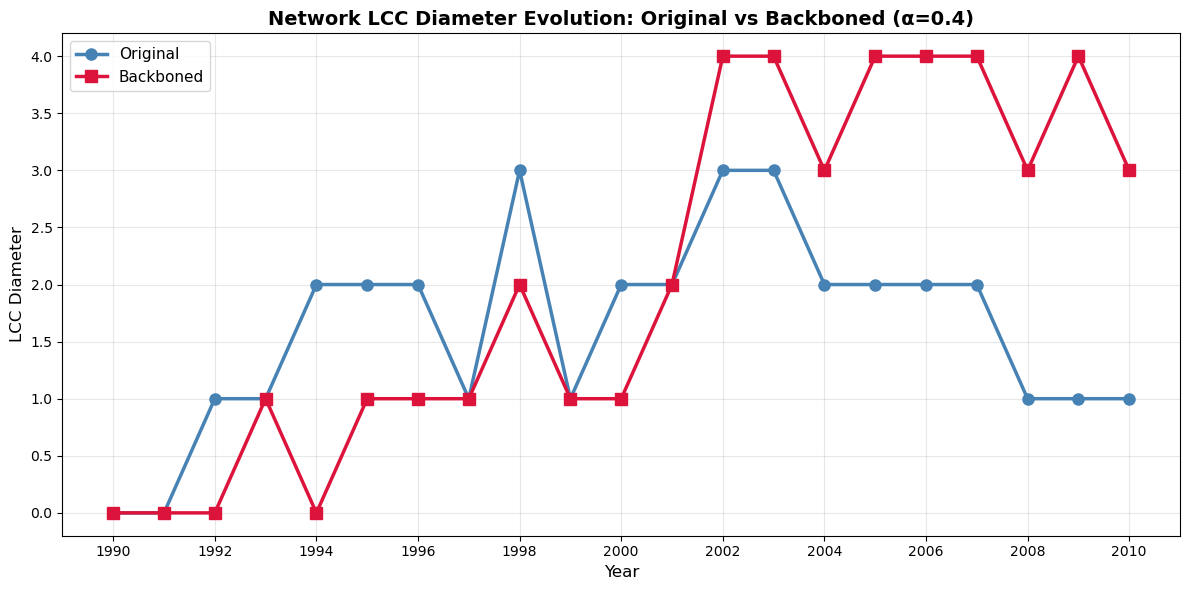

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_diam_evol['year'], df_diam_evol['og_diam'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_diam_evol['year'], df_diam_evol['bb_diam'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Diameter', fontsize=12)
plt.title(f'Network LCC Diameter Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

It makes sense that the diameter stays high in the backboned version, since it reveals more significant structures, and not all families stay connected if their connection is noisy.

#### APL

In [26]:
APL_evol = {'year': [], 'bb_apl': [], 'og_apl': []}

for year in range(min_year, max_year + 1):
    APL_evol['year'].append(year)

    # Original network APL
    if nx.is_connected(G_original[year]):
        og_apl = nx.average_shortest_path_length((G_original[year]))
    else:
        # Get largest connected component
        lcc_og = max(nx.connected_components(G_original[year]), key=len)
        G_lcc_og = G_original[year].subgraph(lcc_og)
        og_apl = nx.average_shortest_path_length(G_lcc_og)

    APL_evol['og_apl'].append(og_apl)
    
    # Backboned network APL
    if nx.is_connected(G_backboned[year]):
        bb_apl = nx.average_shortest_path_length((G_backboned[year]))
    else:
        # Get largest connected component
        lcc_bb = max(nx.connected_components(G_backboned[year]), key=len)
        G_lcc_bb = G_backboned[year].subgraph(lcc_bb)
        bb_apl = nx.average_shortest_path_length(G_lcc_bb)

    APL_evol['bb_apl'].append(bb_apl)
    
df_apl_evol = pd.DataFrame(APL_evol)
df_apl_evol

,year,bb_apl,og_apl
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,1.000000
3,1993,1.000000,1.000000
4,1994,0.000000,1.333333
5,1995,1.000000,1.333333
6,1996,1.000000,1.333333
7,1997,1.000000,1.000000
8,1998,1.333333,1.800000
9,1999,1.000000,1.000000


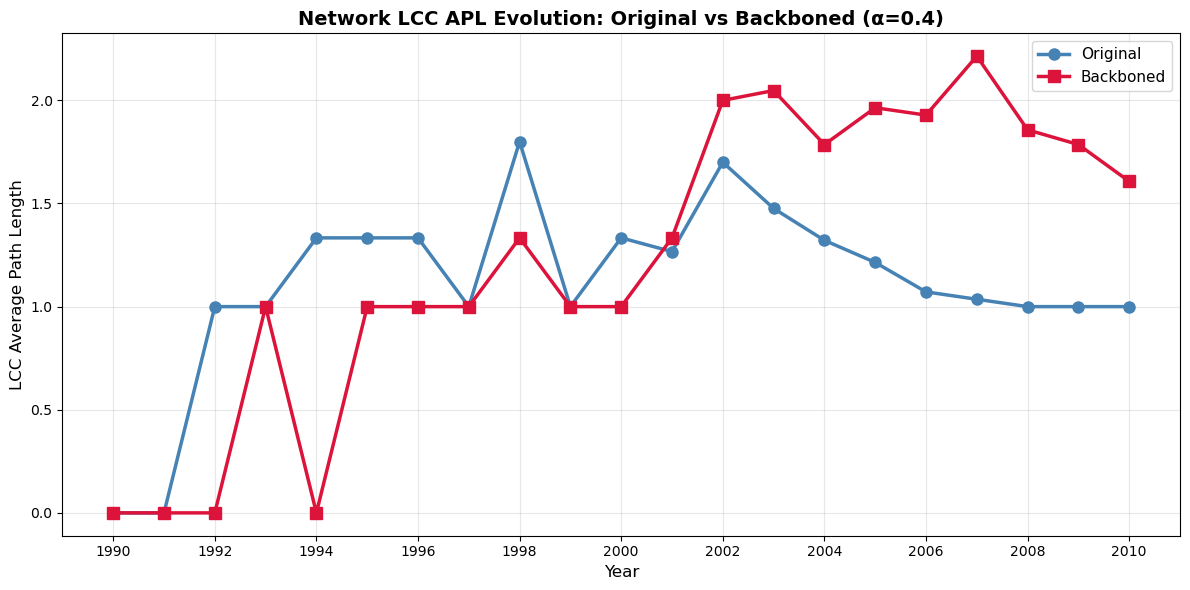

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_apl_evol['year'], df_apl_evol['og_apl'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_apl_evol['year'], df_apl_evol['bb_apl'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('LCC Average Path Length', fontsize=12)
plt.title(f'Network LCC APL Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_apl_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Diameter & APL: Structural Evolution Analysis

---

### 2007: Maximum Fragmentation

**Network Characteristics:**
- **Highest APL:** 2.17
- **Highest Diameter:** 4
- **Most aggressive edge filtering**

**Hypothesis - Evenly Distributed Co-occurrence:**

The 2007 spike reveals a network with uniform, weak territorial overlap:
- Most family pairs had similar low-to-moderate territorial overlap
- Few very strong ties to anchor the network
- NC test removed most edges → sparse, chain-like backbone
- Families connected through intermediaries rather than directly
- Network became highly hierarchical/modular

**Interpretation:**  
2007 marks a **transitional period** where no clear territorial dominance existed. The uniform weight distribution suggests families were competing for control with similar (weak) strength, leading to maximum structural fragmentation when noise is removed.

---

### 2010: Concentrated Strength

**Network Characteristics:**
- **Lower APL:** 1.60 (despite elevated diameter)
- **More edges retained** (higher density than 2007)
- **Strong core + weak periphery structure**

**Hypothesis - Concentrated Weight Distribution:**

The 2010 network shows consolidation of power:
- A few family pairs dominated territorial overlap (high weights → passed NC test)
- Many moderate ties also survived filtering
- Result: denser backbone with clear hierarchical structure
- Some families emerged as dominant players with strong alliances

**Interpretation:**  
By 2010, the network had **consolidated** into a more integrated structure. The heterogeneous weight distribution indicates winner-take-all dynamics where powerful families established strong coalitions, while maintaining strategic moderate ties with others.

---

### Historical Context: Mexican Drug War Timeline

| Period | Structural Pattern | Socio-political Interpretation |
|--------|-------------------|-------------------------------|
| **2004-2006** | Moderate APL/Diameter | Emerging territorial competition |
| **2007** | **Peak fragmentation** (APL=2.17, d=4) | War for territorial control; no dominant alliances |
| **2008-2010** | Consolidation (APL↓, d stable) | Winner-take-all dynamics; strong coalitions formed |

**Key Insight:** The 2007 spike is the **structural signature** of the Mexican Drug War's escalation period (2006-2008), capturing the transition from distributed conflict to concentrated power.


---
#### Avg CC 
We want to answer the question: how are new connections added over time? do they tend to close triads?

In [29]:
avg_cc_evol = {'year': [], 'bb_avg_cc': [], 'og_avg_cc': []}

for year in range(min_year, max_year + 1):
    avg_cc_evol['year'].append(year)

    # Original network average clustering coefficient (weighted)
    og_avg_cc = nx.average_clustering(G_original[year])
    avg_cc_evol['og_avg_cc'].append(og_avg_cc)
    
    # Backboned network average clustering coefficient (weighted)
    bb_avg_cc = nx.average_clustering(G_backboned[year])
    avg_cc_evol['bb_avg_cc'].append(bb_avg_cc)
    
df_cc_evol = pd.DataFrame(avg_cc_evol)
df_cc_evol

,year,bb_avg_cc,og_avg_cc
0,1990,0.000000,0.000000
1,1991,0.000000,0.000000
2,1992,0.000000,0.000000
3,1993,0.000000,0.000000
4,1994,0.000000,0.000000
5,1995,0.000000,0.000000
6,1996,0.000000,0.291667
7,1997,0.000000,0.000000
8,1998,0.000000,0.000000
9,1999,0.000000,0.000000


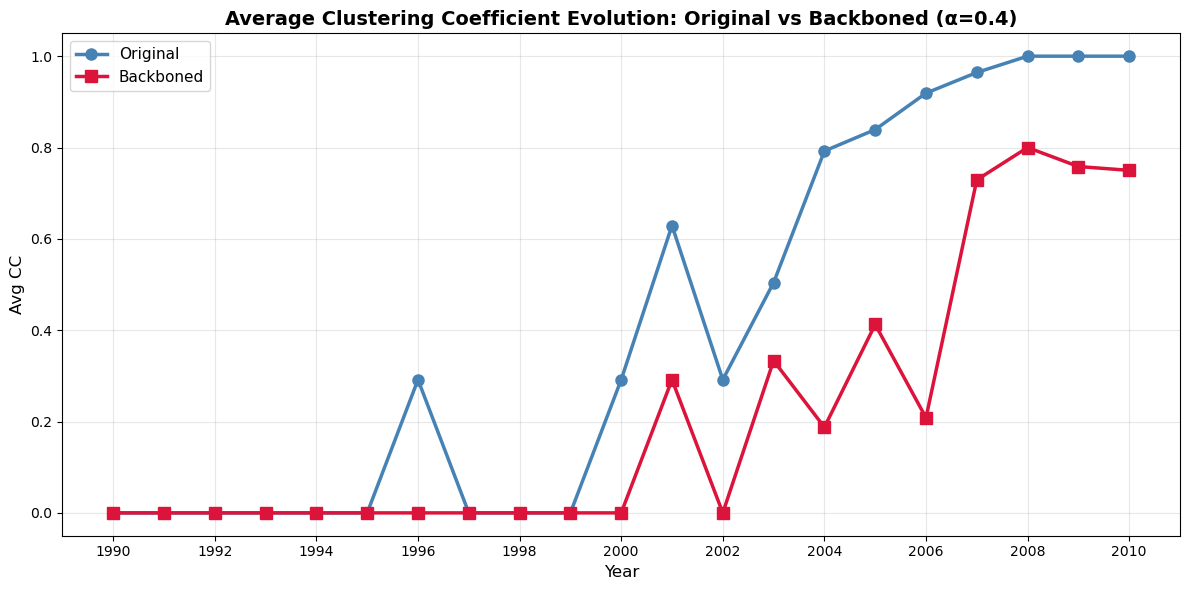

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_cc_evol['year'], df_cc_evol['og_avg_cc'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_cc_evol['year'], df_cc_evol['bb_avg_cc'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg CC', fontsize=12)
plt.title(f'Average Clustering Coefficient Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_avg_cc_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

### Clustering Coefficient Evolution: Interpretation

---

#### 2004: High CC Despite Moderate Density → Strategic Coalition Testing

**Observed Pattern:**
- **Original Network:** Density = 0.68, Average CC = 0.79
- **Backboned Network:** Density = 0.36 (-47%), Average CC = 0.19 (-76%)

**What This Reveals:**

1. **Preferential Triadic Closure (Alliance Behavior)**
   - When families formed new territorial overlaps in 2004, they preferentially closed triangles
   - High CC relative to density indicates **strategic alliance-seeking** rather than random territorial expansion
   - Classic signature: "My ally's ally becomes my ally"

2. **Weak Triangle Dominance (Noise Layer)**
   - **76% of triangles were formed by weak ties** (removed by backboning)
   - Surface appeared highly clustered, but most coalitions were superficial
   - Families were **testing alliances** through exploratory overlaps

3. **Sparse Core Structure (Strategic Selectivity)**
   - Backboned network reveals only **19% clustering** survived
   - Core alliances were **selective, not gregarious**
   - Strong ties formed a **less clustered backbone** → hierarchical rather than democratic structure

**Historical Context (Pre-Drug War):**
- 2004 marks a **transitional period** before the 2006 Mexican Drug War escalation
- Families were exploring coalitions through weak territorial overlaps
- Strong alliances remained selective (core structure)
- Network shows **coalition testing** rather than consolidated power

---

#### Clustering Evolution: Alliance Formation Dynamics

| Year | Original CC | Backboned CC | CC Retention | Interpretation |
|------|-------------|--------------|--------------|----------------|
| **2004** | 0.79 | 0.19 | 24% | Coalition testing; weak exploratory ties |
| **2007** | 0.50 | 0.33 | 66% | Fragmentation; survivors are genuine alliances |
| **2008-2010** | 0.97-1.0 | 0.73-0.80 | 75-80% | Consolidation; strong dense coalitions |

**Key Insight:**
- **2004:** High surface clustering masks sparse strong core (exploration)
- **2007:** Lower clustering, but higher retention → fragmentation reveals genuine ties
- **2008-2010:** Dense clustering with high retention → consolidated strong alliances

**Interpretation:**
The evolution from 2004 to 2010 shows a transition from **exploratory weak coalitions** (many noisy triangles) to **consolidated strong alliances** (fewer but genuine triangles). The 2007 fragmentation period acts as a **filter**, removing weak alliances and revealing the skeleton of future power structures.

---

#### Comparison: Density vs. Clustering

**Why High CC with Moderate Density?**
- **Random network:** CC ≈ Density (triangles form by chance)
- **Clustered network:** CC > Density (triangles form preferentially)
- **2004 Original:** CC/Density = 1.16 → **Moderate preferential clustering**
- **2004 Backboned:** CC/Density = 0.53 → **Core is less clustered than periphery**

**Conclusion:**
The backboned network reveals that **strong alliances were strategic** (selective ties) while **weak alliances were gregarious** (many exploratory triangles). This dual structure suggests families were simultaneously:
1. Testing multiple coalitions (periphery)
2. Maintaining selective strong partnerships (core)

This pattern is consistent with **pre-conflict coalition dynamics** where organizations explore alliances before committing to concentrated partnerships during conflict.

---
### Conclusion from Analysis of Basic Metrics Evolution

#### **The Paradox: War Led to Consolidation, Not Fragmentation**

**Conventional Expectation:**
```
Government crackdown → Cartels weaken → Network fragments
```

**What Actually Happened (Our Data Shows):**
```
Government crackdown → Weak alliances collapse → Strong coalitions emerge → Network consolidates
```

---

#### **Evidence from Network Evolution Analysis**
Mexican Drug War context [here](https://en.wikipedia.org/wiki/Mexican_drug_war)

#### **Pre-War Period (2004-2006): Exploratory Chaos**
- **High clustering, low retention** (76% of triangles were weak)
- Many families testing alliances
- Surface appears organized, but underlying structure is fragmented
- **Interpretation:** DTOs spread thin, trying multiple partnerships

#### **War Period (2007): The Filter**
- **Fragmentation spike** (APL = 2.17, diameter = 4)
- Weak alliances fail under pressure
- Only 66% of clustering survives (but these are **genuine** ties)
- **Interpretation:** Conflict acts as a **stress test** for alliances

#### **Post-War Consolidation (2008-2010): Winner-Take-All**
- **Dense clustering with high retention** (75-80%)
- Network becomes almost fully connected (CC ≈ 1.0)
- Strong coalitions dominate
- **Interpretation:** Survivors formed **unbreakable alliances**

---

#### **Why This Happened: The "Alliance Under Fire" Effect**

#### **Mechanism:**

1. **Weak ties collapse under government pressure**
   - Exploratory partnerships can't withstand raids, arrests
   - Fair-weather allies abandon each other

2. **Strong ties get stronger through shared adversity**
   - Families that survive together bond deeper
   - Mutual defense becomes existential necessity
   - "The enemy of my enemy is now my **essential** ally"

3. **Network consolidates into tight coalitions**
   - Winners dominate territory with strong partnerships
   - Losers are eliminated or absorbed
   - **Result:** Oligopolistic structure replaces competitive chaos

---

### **Policy Implication: The Hydra Effect**

**What Policymakers Expected:**
```
High enforcement → Disrupt networks → Reduce cartel power
```

**What Actually Happened (Our Data):**
```
High enforcement → Kill weak alliances → Strengthen surviving coalitions
```

---

### **Key Finding:**

> **"The Mexican Drug War transformed a fragmented landscape of exploratory alliances into a consolidated network of battle-tested coalitions, making organized crime structurally stronger despite individual losses."**

---

### **The Uncomfortable Truth:**

**You can't "win" a War on Drugs through enforcement.**

But you CAN:

- ✅ **Reduce violence** (public health > punishment)
- ✅ **Weaken cartels financially** (starve profits)
- ✅ **Break recruitment cycles** (education + jobs)
- ✅ **Minimize corruption** (strong institutions)
- ✅ **Save lives** (treatment > incarceration)

**Our network analysis provides quantitative evidence that enforcement-focused strategies paradoxically strengthen surviving criminal organizations—suggesting policy must shift from attacking actors to attacking incentives.**

# TBC: BELOW

---

### Assortativity Analysis: Power-based Edge Scatterplot

Testing whether powerful families (high municipal presence) preferentially co-occur with other powerful families

In [ ]:
# Calculate municipal presence for each family by year
def get_municipal_presence(df, year):
    """Returns dict {family: number of municipalities they're present in}"""
    df_year = df[df['Year'] == year]
    presence = {}
    for family in families:
        presence[family] = (df_year[family] > 0).sum()
    return presence

# Test for one year
presence_2010 = get_municipal_presence(df, 2010)
print("Municipal presence in 2010:")
for family, count in sorted(presence_2010.items(), key=lambda x: x[1], reverse=True):
    print(f"  {family}: {count} municipalities")

In [ ]:
# Create edge scatterplot for selected years
years_to_plot = [2004, 2007, 2010]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, year in enumerate(years_to_plot):
    presence = get_municipal_presence(df, year)
    
    # Original network
    ax_orig = axes[0, idx]
    G_orig = G_original[year]
    
    u_presence_orig = []
    v_presence_orig = []
    weights_orig = []
    
    for u, v, data in G_orig.edges(data=True):
        u_presence_orig.append(presence[u])
        v_presence_orig.append(presence[v])
        weights_orig.append(data['weight'])
    
    if weights_orig:
        scatter = ax_orig.scatter(u_presence_orig, v_presence_orig, 
                                 s=[w*10 for w in weights_orig],  # Scale point size
                                 c=weights_orig, cmap='YlOrRd', 
                                 alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax_orig)
        cbar.set_label('Co-occurrence count', fontsize=10)
        
        # Calculate correlation
        if len(u_presence_orig) > 1:
            corr = np.corrcoef(u_presence_orig, v_presence_orig)[0, 1]
            ax_orig.text(0.05, 0.95, f'r = {corr:.3f}', 
                        transform=ax_orig.transAxes, fontsize=11,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax_orig.set_xlabel('Municipal presence (family u)', fontsize=11)
    ax_orig.set_ylabel('Municipal presence (family v)', fontsize=11)
    ax_orig.set_title(f'{year} - Original', fontsize=12, fontweight='bold')
    ax_orig.grid(True, alpha=0.3)
    ax_orig.set_aspect('equal')
    
    # Backboned network
    ax_bb = axes[1, idx]
    G_bb = G_backboned[year]
    
    u_presence_bb = []
    v_presence_bb = []
    weights_bb = []
    
    for u, v, data in G_bb.edges(data=True):
        u_presence_bb.append(presence[u])
        v_presence_bb.append(presence[v])
        weights_bb.append(data['weight'])
    
    if weights_bb:
        scatter = ax_bb.scatter(u_presence_bb, v_presence_bb, 
                               s=[w*10 for w in weights_bb],
                               c=weights_bb, cmap='YlOrRd', 
                               alpha=0.6, edgecolors='black', linewidth=0.5)
        
        cbar = plt.colorbar(scatter, ax=ax_bb)
        cbar.set_label('Co-occurrence count', fontsize=10)
        
        # Calculate correlation
        if len(u_presence_bb) > 1:
            corr = np.corrcoef(u_presence_bb, v_presence_bb)[0, 1]
            ax_bb.text(0.05, 0.95, f'r = {corr:.3f}', 
                      transform=ax_bb.transAxes, fontsize=11,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax_bb.set_xlabel('Municipal presence (family u)', fontsize=11)
    ax_bb.set_ylabel('Municipal presence (family v)', fontsize=11)
    ax_bb.set_title(f'{year} - Backboned (α={alpha_value})', fontsize=12, fontweight='bold')
    ax_bb.grid(True, alpha=0.3)
    ax_bb.set_aspect('equal')

plt.tight_layout()
plt.savefig('../presentation/assortativity_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Mesoscale analysis: PLAN  
- Identification of clusters/modules (communities) - there will likely be 2  
- Roles within (core) and between (bridge) communities
- Answers: "What groups exist and how are they organized?"

How to do it:  
1. Betweenness centrality - High values indicate bridges (many paths pass through them)
2. Within-community degree z-score - High values indicate cores (well-connected within their module)
3. Participation coefficient - High values indicate bridges (connections spread across communities)

### Social Balance Theory